# Demo of VAE for anomaly detection of diverse sensor data
Trained on non-fault data to learn a normal expectation.

Build the model for 512 time points per cycle with 14 sensors.

In [1]:
%matplotlib inline

In [2]:
from IPython.core.debugger import set_trace

In [3]:
from demo import *
device

device(type='cuda', index=0)

In [4]:
model = VAE1D(size, n_channels, n_latent)
model = model.to(device)
print(f"Time-series size = {size}, number of sensors = {n_channels}, "
      f"latent size = {n_latent}")

Time-series size = 512, number of sensors = 14, latent size = 50


Load the best parameters from training.

In [5]:
model = load_checkpoint(model, device)

Checkpoint Performance:
Validation loss: 14.268
Epoch: 210


In [6]:
params = model.demo()

Input size: torch.Size([1, 14, 512])
Encoded size: torch.Size([1, 1024, 4])
Latent size: torch.Size([1, 50, 1])
Decoded (output) size: torch.Size([1, 14, 512])


In [7]:
X, E, L, D = [param.cpu().detach().numpy() for param in params]
MSE = np.power((X - D), 2).sum() / 2
print(f"MSE of random data = {MSE:.3f}")

MSE of random data = 671.492


In [8]:
X[:, :4, :4]

array([[[0.69596785, 0.6416701 , 0.31699163, 0.99723166],
        [0.2288084 , 0.8130098 , 0.11882985, 0.21485479],
        [0.13421142, 0.9291483 , 0.81305087, 0.5222764 ],
        [0.05363974, 0.52779406, 0.9185823 , 0.4630374 ]]], dtype=float32)

In [9]:
D[:, :4, :4]

array([[[ 0.22645082,  0.22277105,  0.25117716,  0.45894414],
        [ 0.32490996,  0.11751233,  0.06151637, -0.01564838],
        [ 0.6780464 ,  0.6643398 ,  0.63121796,  0.58662575],
        [ 0.20309983,  0.31348604,  0.35275283,  0.6211086 ]]],
      dtype=float32)

Next we need to load the datasets of sensors readings.

In [10]:
data_path = Path(f'data/hydraulic/{desc}')
train_dl, val_dl, test_dl = load_datasets(data_path)

In [11]:
print(len(train_dl), len(val_dl), len(test_dl))

27 7 1157


Let's get some random samples from the dataset for examples and generate new versions.

In [12]:
data, targets = get_random_samples(test_dl)  #, 20)

In [88]:
classes = list_target_classes(test_dl)

0 = fail
1 = norm


In [14]:
targets = targets.cpu().numpy()
targets

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
print('normals = ', targets.sum())

normals =  349


In [48]:
print('failures = ', len(targets) - targets.sum())

failures =  808


In [16]:
criterion = VAE1DLoss()
criterion = criterion.to(device)

In [17]:
model.eval()
with torch.no_grad():
    # Generate
    data = data.to(device)
    gen_data, mu, logvar = model(data)
    loss, loss_desc = criterion(gen_data, data, mu, logvar, reduce=False)
    

In [18]:
gen_err = -loss_desc['logp']
gen_err

tensor([17.3780,  2.8146,  0.8533,  ...,  1.7603,  2.7822, 23.0919],
       device='cuda:0')

[[-0.06045532 -0.06087831 -0.03702804 -0.03245969 -0.02400351]
 [-0.03504689 -0.02282584  0.0252088   0.01946014  0.04400054]
 [-0.19187385 -0.08431354 -0.114986   -0.04279441 -0.05897728]
 [ 0.01723029 -0.01504016  0.03518674  0.01051193  0.04553676]
 [ 0.03585735 -0.01783724  0.02805119 -0.07869689 -0.03445744]]
MSE = 17.377986907958984


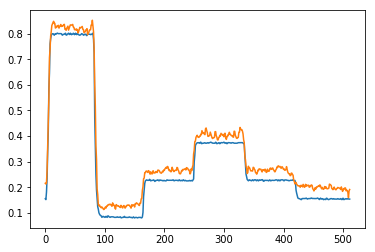

In [19]:
idx = 0
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

[[-0.00593165 -0.0273225  -0.00360838 -0.06213176 -0.00058699]
 [-0.04079382 -0.01489974  0.01415359  0.01113624  0.0225776 ]
 [ 0.01246762 -0.02150342 -0.03476417  0.03576592  0.02500486]
 [ 0.0550869   0.0009909   0.06429219  0.03985512  0.10085726]
 [ 0.05071542 -0.02323241  0.00494441 -0.03591237 -0.03212146]]
MSE = 2.8145618438720703


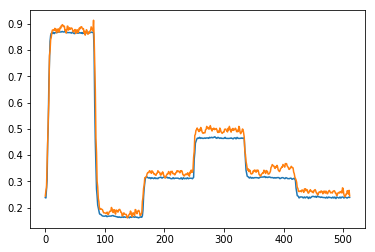

In [20]:
idx = 1
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

In [49]:
err = np.zeros(targets.shape)
for i, target in enumerate(targets):
    err[i] = -loss_desc['logp'][i]
    print(f"Target = {target}, MSE = {err[i]:.3f}")
    if i > 10:
        break

Target = 0, MSE = 17.378
Target = 0, MSE = 2.815
Target = 0, MSE = 0.853
Target = 1, MSE = 2.572
Target = 1, MSE = 1.347
Target = 0, MSE = 2.468
Target = 1, MSE = 1.933
Target = 0, MSE = 1.132
Target = 0, MSE = 4.897
Target = 0, MSE = 3.534
Target = 0, MSE = 23.370
Target = 1, MSE = 1.491


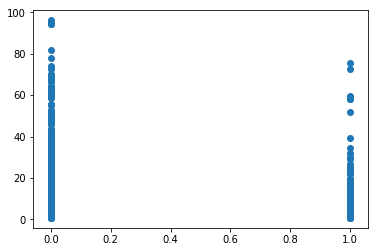

In [22]:
plt.scatter(targets, err)

Show the data plots.

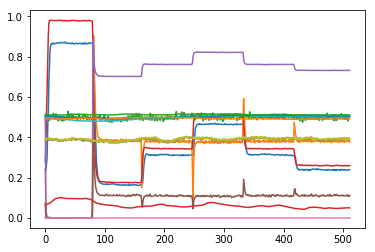

In [50]:
show_plot(sample)

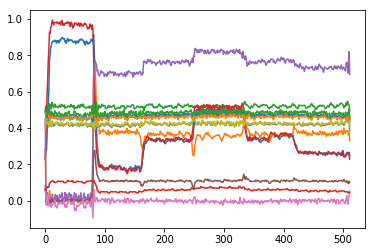

In [24]:
show_plot(gen_sample)

Let's score the success of the recreation and look for outliers.

In [25]:
scores = score(test_dl, model, criterion)

100%|██████████| 1157/1157 [00:07<00:00, 148.49it/s]


In [26]:
test_means = pd.DataFrame()
for (name, cls), item in scores.items():
    test_means.loc[name, cls] = np.array(item).mean()

print("###################### TEST MEANS #####################")
print(test_means)

###################### TEST MEANS #####################
            fail       norm
loss   76.618521  43.947223
KL     62.811791  37.950420
error  13.806730   5.996803


In [27]:
val_means = pd.DataFrame()
for (name, cls), item in score(val_dl, model, criterion).items():
    val_means.loc[name, cls] = np.array(item).mean()

print("###################### VAL MEANS #####################")
print(val_means)

100%|██████████| 7/7 [00:01<00:00,  5.46it/s]

###################### VAL MEANS #####################
            norm
loss   43.087121
KL     37.345048
error   5.742073


In [51]:
train_means = pd.DataFrame()
for (name, cls), item in score(train_dl, model, criterion).items():
    train_means.loc[name, cls] = np.array(item).mean()

print("###################### TRAIN MEANS #####################")
print(train_means)

100%|██████████| 27/27 [00:04<00:00,  5.69it/s]

###################### TRAIN MEANS #####################
            norm
loss   42.833948
KL     37.370792
error   5.463156


Let's calculate AUC to judge performance.

In [29]:
scores.keys()

dict_keys([('loss', 'fail'), ('loss', 'norm'), ('KL', 'fail'), ('KL', 'norm'), ('error', 'fail'), ('error', 'norm')])

In [52]:
print(len(scores[('error', 'norm')]), len(scores[('error', 'fail')]))

349 808


In [66]:
# simple definition of the threshold as mean between sets
threshold = (np.mean(scores['error', 'fail']) +
             np.mean(scores['error', 'norm'])) / 2
print('mean threshold:', threshold)
# maximum 95% percentile of normal as threshold
threshold = np.percentile(scores['error', 'norm'], 95)
print('95th percentile threshold:', threshold)

mean threshold: 9.901766169855465
95th percentile threshold: 22.191242599487282


In [67]:
t_scores = scores.copy()
t_scores[('error', 'fail')] = (t_scores[('error', 'fail')] >= threshold)
t_scores[('error', 'norm')] = (t_scores[('error', 'norm')] < threshold)
t_score = []
t_score.extend(t_scores[('error', 'fail')])
t_score.extend(t_scores[('error', 'norm')])

In [68]:
t_corr = t_score == y_true

In [69]:
t_corr.sum() / len(t_corr)

0.7865168539325843

In [70]:
auc_scores = auc_score(test_dl, t_scores)
auc_scores

0.832504113591875

In [71]:
np.mean(scores['error', 'norm'])

5.9968026399954

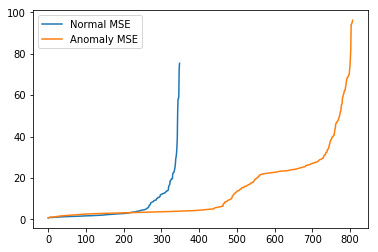

In [72]:
normaly = sorted(scores[('error', 'norm')])
anomaly = sorted(scores[('error', 'fail')])
plt.plot(normaly, label='Normal MSE')
plt.plot(anomaly, label='Anomaly MSE')
plt.legend()

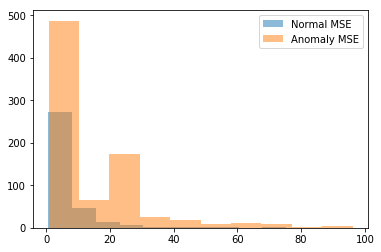

In [74]:
plt.hist(normaly, label='Normal MSE', alpha=0.5)
plt.hist(anomaly, label='Anomaly MSE', alpha=0.5)
plt.legend()

In [75]:
normalx = np.random.rand(len(normaly))
anomalx = np.random.rand(len(anomaly))

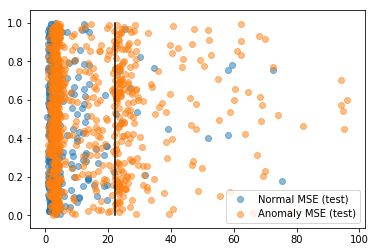

In [76]:
plt.scatter(normaly, normalx, label='Normal MSE (test)', alpha=0.5)
plt.scatter(anomaly, anomalx, label='Anomaly MSE (test)', alpha=0.5)
plt.plot([threshold, threshold], [0, 1], 'k-')
plt.legend()

Try fitting a normal distribution to the validation MSE to define a threshold.

In [77]:
val_scores = score(val_dl, model, criterion)

100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


In [78]:
val_scores.keys()

dict_keys([('loss', 'norm'), ('KL', 'norm'), ('error', 'norm')])

[0.7376766800880432, 0.8296641111373901, 0.8428189754486084, 0.8497141599655151, 0.9164765477180481]
mean=5.74, stdev=9.53


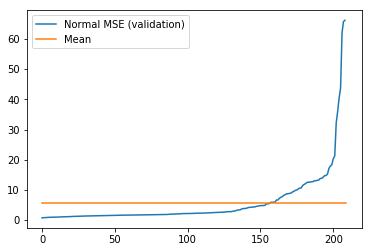

In [79]:
val_norm = sorted(val_scores[('error', 'norm')])
print(val_norm[:5])
mean = np.mean(val_norm)
std = np.std(val_norm)
print('mean={:.2f}, stdev={:.2f}'.format(mean, std))
plt.plot(val_norm, label= 'Normal MSE (validation)')
plt.plot([0, len(val_norm)], [mean, mean], label='Mean')
plt.legend()

Implement PCA to visualize the latent space.

In [80]:
latents, targets = compute_latent(test_dl, model)

100%|██████████| 1157/1157 [00:07<00:00, 151.62it/s]


In [81]:
from sklearn.decomposition import PCA

In [82]:
pca = PCA(n_components=2)

In [83]:
lat_pca = pca.fit_transform(latents)

In [84]:
lat_pca.shape

(1157, 2)

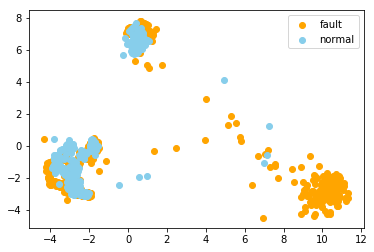

In [108]:
fail_mask = targets == 0
norm_mask = targets == 1
plt.scatter(lat_pca[fail_mask, 0], lat_pca[fail_mask, 1],
            c='orange', label='fault')
plt.scatter(lat_pca[norm_mask, 0], lat_pca[norm_mask, 1],
            c='skyblue', label='normal')
plt.legend()

In [109]:
pca.explained_variance_ratio_

array([0.40815395, 0.27905816], dtype=float32)

Cluster the latent space into kmeans clusters.

In [99]:
from sklearn.cluster import KMeans

In [110]:
kmeans = KMeans(3)

In [111]:
lat_k = kmeans.fit_transform(latents)

In [112]:
lat_k.shape

(1157, 3)

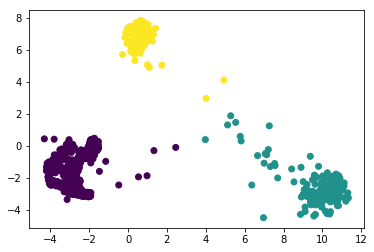

In [113]:
plt.scatter(lat_pca[:, 0], lat_pca[:, 1], c=kmeans.labels_)

Try adding the error terms to the latent features.

In [115]:
latents, kl, error, targets = compute_latent_and_loss(test_dl, model, criterion)

100%|██████████| 1157/1157 [00:07<00:00, 147.90it/s]


In [116]:
print(latents.shape, kl.shape, error.shape, targets.shape)

(1157, 50) (1157,) (1157,) (1157,)


In [117]:
features = np.hstack([latents, kl[:, None], error[:, None]])
features.shape

(1157, 52)

In [118]:
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(features)
lat_pca.shape

(1157, 2)

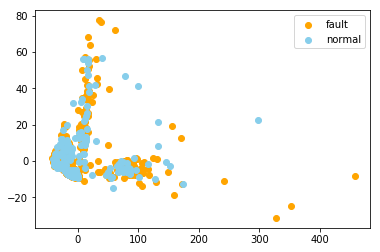

In [120]:
plt.scatter(lat_pca[fail_mask, 0], lat_pca[fail_mask, 1],
            c='orange', label='fault')
plt.scatter(lat_pca[norm_mask, 0], lat_pca[norm_mask, 1],
            c='skyblue', label='normal')
plt.legend()

In [121]:
pca.explained_variance_ratio_

array([0.92956803, 0.05661349])

Compare the pca plots for validation and training sets.

100%|██████████| 27/27 [00:04<00:00,  5.86it/s]


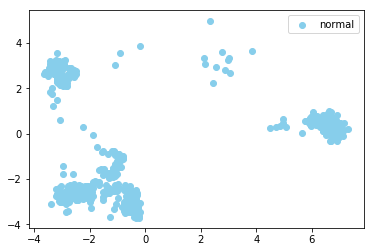

In [123]:
latents, targets = compute_latent(train_dl, model)
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(latents)
plt.scatter(lat_pca[:, 0], lat_pca[:, 1],
            c='skyblue', label='normal')
plt.legend()

100%|██████████| 7/7 [00:01<00:00,  5.43it/s]


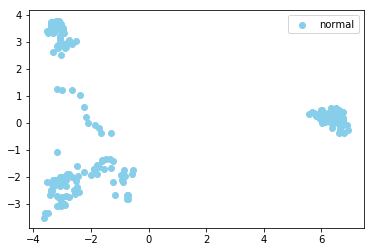

In [125]:
latents, targets = compute_latent(val_dl, model)
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(latents)
plt.scatter(lat_pca[:, 0], lat_pca[:, 1],
            c='skyblue', label='normal')
plt.legend()